In [1]:
# Import Necessary Libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import os

import pandas as pd
from PIL import Image
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn import metrics

import cv2
import gc
import os

from tensorflow import keras
from keras import layers
import shutil
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the Pre-trained Model
model_path = '/home/mandal.n/VML/Project/cnn_model.h5'  # Update with the path to your .h5 file
cnn_model = load_model(model_path)
print("Model loaded successfully.")

Model loaded successfully.


In [3]:
path = '/home/mandal.n/VML/Project/Data/image_sets'
classes = [folder for folder in os.listdir(path) if folder != '.ipynb_checkpoints']
#classes = os.listdir(path)
classes

['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc']

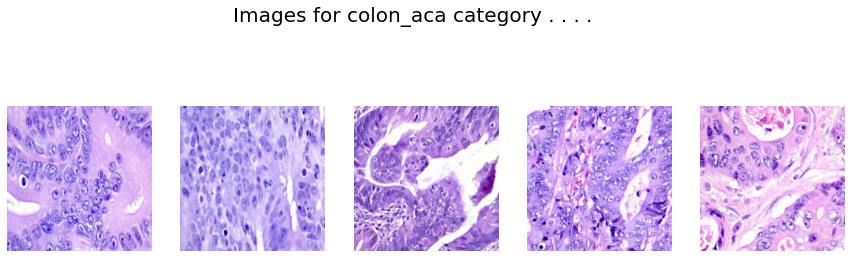

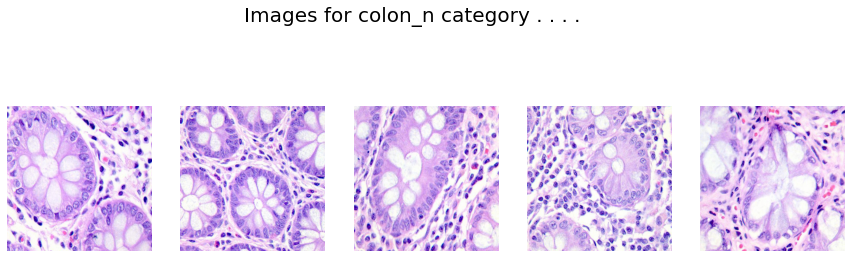

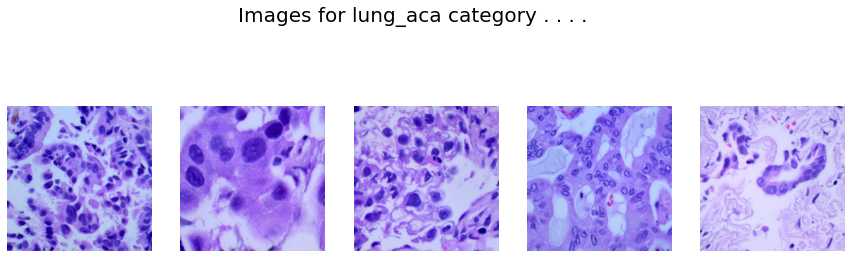

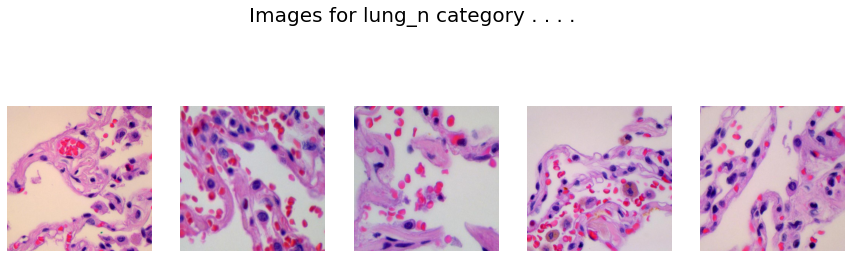

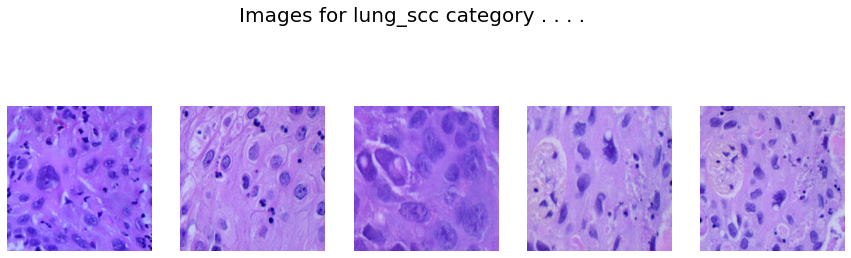

In [4]:
path = '/home/mandal.n/VML/Project/Data/image_sets'

for cat in classes:
	image_dir = f'{path}/{cat}'
	images = os.listdir(image_dir)

	fig, ax = plt.subplots(1, 5, figsize=(15, 5))
	fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)

	for i in range(5):
		k = np.random.randint(0, len(images))
		img = np.array(Image.open(f'{path}/{cat}/{images[k]}'))
		ax[i].imshow(img)
		ax[i].axis('off')
	plt.show()

In [5]:
def pgd_attack(model, images, labels, epsilon=0.03, alpha=0.01, num_iter=40):
    """
    Perform PGD attack with debugging to inspect intermediate pixel values.

    Parameters:
        model (tf.keras.Model): Trained model to attack.
        images (tf.Tensor): Input images.
        labels (tf.Tensor): Corresponding labels.
        epsilon (float): Maximum perturbation.
        alpha (float): Step size.
        num_iter (int): Number of attack iterations.

    Returns:
        adv_images (tf.Tensor): Adversarial images.
    """
    labels_one_hot = tf.one_hot(labels, depth=5)  # Adjust depth for your number of classes
    adv_images = tf.identity(images)  # Copy of original images

    print("Initial image pixel range:", tf.reduce_min(adv_images).numpy(), "-", tf.reduce_max(adv_images).numpy())

    for i in range(num_iter):
        with tf.GradientTape() as tape:
            tape.watch(adv_images)
            predictions = model(adv_images)
            loss = tf.keras.losses.categorical_crossentropy(labels_one_hot, predictions)

        gradients = tape.gradient(loss, adv_images)

        # Print gradient statistics
        print(f"Iteration {i+1}: Gradient range:", tf.reduce_min(gradients).numpy(), "-", tf.reduce_max(gradients).numpy())

        # Apply perturbation
        adv_images = adv_images + alpha * tf.sign(gradients)

        # Clip adversarial images
        perturbation = tf.clip_by_value(adv_images - images, -epsilon, epsilon)
        adv_images = tf.clip_by_value(images + perturbation, 0, 1)

        # Print pixel value range after clipping
        print(f"Iteration {i+1}: Adversarial image pixel range:", tf.reduce_min(adv_images).numpy(), "-", tf.reduce_max(adv_images).numpy())

    return adv_images


In [6]:
unwanted_dir = '/home/mandal.n/VML/Project/Data/image_sets/.ipynb_checkpoints'
if os.path.exists(unwanted_dir):
    shutil.rmtree(unwanted_dir)
dirpath='/home/mandal.n/VML/Project/Data/image_sets'
#dirpath=[folder for folder in os.listdir(path) if folder != '.ipynb_checkpoints']
IMG_SIZE=180
BATCH_SIZE=32
CHANNELS=3
EPOCHS=20
INPUT_SHAPE = (BATCH_SIZE, IMG_SIZE, IMG_SIZE, CHANNELS)
N_CLASSES = 5

In [7]:
dataset= tf.keras.preprocessing.image_dataset_from_directory(
    dirpath,
    seed=123,
    shuffle=True,
    image_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE
)

Found 8481 files belonging to 5 classes.


In [8]:
# Normalize the images
#test_ds = test_ds.map(lambda x, y: (x / 255.0, tf.one_hot(y, depth=5)))

In [9]:
classes_name=dataset.class_names
classes_name

['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc']

In [10]:
for batch_img,batch_label in dataset.take(1):
    print(batch_img.shape)
    print(batch_label.numpy())

(32, 180, 180, 3)
[0 4 4 1 4 3 3 2 0 4 2 2 0 0 3 1 3 4 4 3 4 4 4 0 2 1 3 2 3 2 3 4]


In [11]:
def split_train_val_test(dataset,train_split=0.8,test_split=0.1,val_split=0.1,shuffle=True,shuffle_size=10000):
   assert(train_split+val_split+test_split)==1


   if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=12)
    #set size of train,test and val
   train_size=int(train_split*len(dataset))
   val_size=int(val_split*len(dataset))
   test_size=int(test_split*len(dataset))


   train_ds=dataset.take(train_size)
   val_ds=dataset.skip(train_size).take(val_size)
   test_ds=dataset.skip(train_size+val_size).take(test_size)


   return train_ds,val_ds,test_ds

In [12]:
train,val,test=split_train_val_test(dataset)

In [13]:
print(len(train))
print(len(test))
print(len(val))

212
26
26


In [14]:
train_ds = train.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.map(lambda x, y: (x / 255.0, y)) \
                 .cache() \
                 .shuffle(1000) \
                 .prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
resize_scaling=tf.keras.Sequential([
    layers.Resizing(IMG_SIZE,IMG_SIZE),
    layers.Rescaling(1./255)
])

In [16]:
for images, labels in test_ds.take(1):
    print(f"Image shape: {images.shape}")
    print(f"Label shape: {labels.shape}")
    print(f"Label data type: {labels.dtype}")

Image shape: (32, 180, 180, 3)
Label shape: (32,)
Label data type: <dtype: 'int32'>


In [20]:
def evaluate_adversarial_examples(model, test_ds, epsilon, alpha, num_iter):
    """
    Evaluate the model on adversarial examples generated using PGD attack.

    Parameters:
        model (tf.keras.Model): Trained model.
        test_ds (tf.data.Dataset): Test dataset.
        epsilon (float): Maximum perturbation.
        alpha (float): Step size for each iteration.
        num_iter (int): Number of PGD iterations.
    """
    adv_accuracy = 0
    total_samples = 0
    for images, labels in test_ds:
        # Generate adversarial examples
        adv_images = pgd_attack(model, images, labels, epsilon=epsilon, alpha=alpha, num_iter=num_iter)
        
        # Get predictions for adversarial examples
        predictions = model.predict(adv_images)
        predicted_classes = np.argmax(predictions, axis=1)  # Predicted class indices
        
        # Compare predicted classes with true class labels
        adv_accuracy += np.sum(predicted_classes == labels.numpy())  # Direct comparison
        total_samples += labels.shape[0]
    
    adv_accuracy /= total_samples
    print(f"Accuracy on adversarial examples: {adv_accuracy * 100:.2f}%")


In [21]:
def visualize_adversarial_examples(model, test_ds, epsilon=0.03, alpha=0.01, num_iter=5, num_samples=5):
    """
    Visualize original and adversarial examples with debugging.

    Parameters:
        model (tf.keras.Model): Trained model.
        test_ds (tf.data.Dataset): Test dataset.
        epsilon (float): Maximum perturbation.
        alpha (float): Step size for each iteration.
        num_iter (int): Number of PGD iterations.
        num_samples (int): Number of images to visualize.
    """
    for images, labels in test_ds.take(1):  # Take one batch
        adv_images = pgd_attack(model, images, labels, epsilon=epsilon, alpha=alpha, num_iter=num_iter)

        # Print pixel range before visualization
        print("Original image pixel range:", tf.reduce_min(images).numpy(), "-", tf.reduce_max(images).numpy())
        print("Adversarial image pixel range:", tf.reduce_min(adv_images).numpy(), "-", tf.reduce_max(adv_images).numpy())

        plt.figure(figsize=(10, 5))
        for i in range(num_samples):
            # Original Image
            plt.subplot(2, num_samples, i + 1)
            plt.imshow((images[i].numpy() * 255).astype("uint8"))  # Scale to [0, 255] if needed
            plt.title("Original")
            plt.axis("off")

            # Adversarial Image
            plt.subplot(2, num_samples, i + 1 + num_samples)
            plt.imshow((adv_images[i].numpy() * 255).astype("uint8"))  # Scale to [0, 255] if needed
            plt.title("Adversarial")
            plt.axis("off")

        plt.tight_layout()
        plt.show()


Initial image pixel range: 0.0 - 1.0
Iteration 1: Gradient range: -0.0017267775 - 0.00140324
Iteration 1: Adversarial image pixel range: 0.0 - 1.0
Iteration 2: Gradient range: -0.0015677044 - 0.0014262887
Iteration 2: Adversarial image pixel range: 0.0 - 1.0
Iteration 3: Gradient range: -0.0019948499 - 0.0011692094
Iteration 3: Adversarial image pixel range: 0.0 - 1.0
Iteration 4: Gradient range: -0.0013388562 - 0.0013233583
Iteration 4: Adversarial image pixel range: 0.0 - 1.0
Iteration 5: Gradient range: -0.0016731268 - 0.0012720582
Iteration 5: Adversarial image pixel range: 0.0 - 1.0
1/1 [==============================] - 0s 441ms/step
Initial image pixel range: 0.0 - 1.0
Iteration 1: Gradient range: -0.0014705927 - 0.0012233382
Iteration 1: Adversarial image pixel range: 0.0 - 1.0
Iteration 2: Gradient range: -0.0013221009 - 0.0012375755
Iteration 2: Adversarial image pixel range: 0.0 - 1.0
Iteration 3: Gradient range: -0.0011025692 - 0.0011729969
Iteration 3: Adversarial image pi

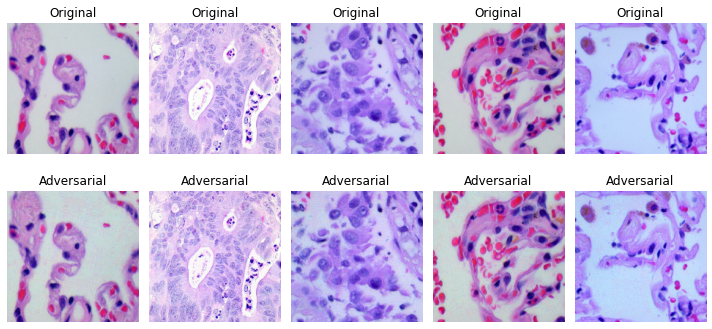

In [22]:
# Evaluate and Visualize
evaluate_adversarial_examples(cnn_model, test_ds, epsilon=0.03, alpha=0.01, num_iter=5)
visualize_adversarial_examples(cnn_model, test_ds, epsilon=0.03, alpha=0.01, num_iter=5)